# Grid Construction
The simplest approach to construct a grid is to
use the `structuredGrid` functions which takes
coordinates of the lower left and upper right
corner of the domain and the subdivision to use
in each coordinate direction.

Setup a Cartesian grid for
$(-\frac{1}{2},2]\times(-\frac{1}{2},1)$
with $10$ cells in the x direction and $20$ in the y direction:

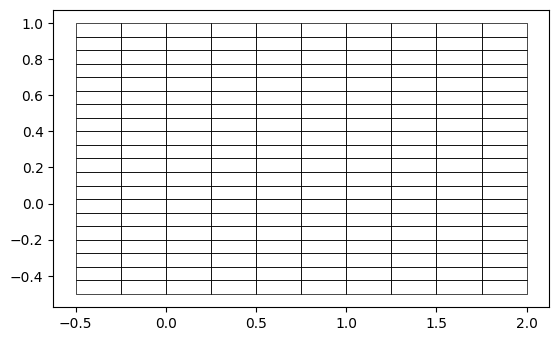

In [1]:
##### TASK
import dune
from dune import grid

grid = dune.grid.structuredGrid((-1/2, -1/2), (2, 1), (10, 20))
grid.plot()

To construct more complicated grids, we
can use Python dictionaries which stores key/value
pairs in the form
```
`{key1:value1, key2:value2,...}`.
```
For example construct some triangular grid using 'ALUGrid`

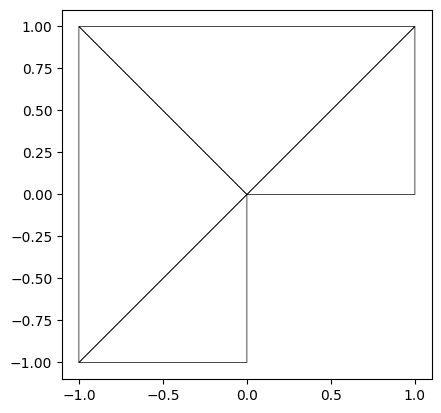

In [2]:
##### TASK
import dune.alugrid
vertices = [(0, 0), (1, 0), (1, 1), (-1, 1), [-1, -1], [0, -1]]
triangles = [(0, 1, 2), (0, 2, 3), (0, 3, 4), [0, 4, 5]]


triangular_grid = dune.alugrid.aluConformGrid({'vertices': vertices, 'simplices': triangles})

triangular_grid.plot()

with four triangles and corners
$(0,0),(1,0),(1,1),(-1,1),(-1,-1),(0,-1)$:

## Using the grid:
The most common task is to iterate over the elements
(codimension zero entities) of the grid.
This can be done with a simple for loop
```
for element in view.elements:
```
The element provides all its geometric
information through the `geometry` property.
The returned object provides all information
concerning the mapping from reference into
physical space, i.e., the center of the element
its volume, the reference mapping, or the coordinates
of the corners using `element.geometry.corners` which returns a vector
of the corner points (in fact it returns a list of `Dune::FieldVector`
instances.

Print the volume and the center for all elements. There are two ways to
obtain the center - try both:

In [3]:
##### TASK
import numpy as np
for element in triangular_grid.elements:
    print(f"center at {element.geometry.center}, with volume {element.geometry.volume}")

for entity in triangular_grid.entities(codim=0):
    calculated_center = np.array(entity.geometry.corners).mean(axis=0)
    print(f"center at {calculated_center}, with volume {entity.geometry.volume}")

center at (-0.333333, -0.666667), with volume 0.5
center at (-0.666667, 0.000000), with volume 1.0
center at (0.666667, 0.333333), with volume 0.5
center at (0.000000, 0.666667), with volume 1.0
center at [-0.33333333 -0.66666667], with volume 0.5
center at [-0.66666667  0.        ], with volume 1.0
center at [0.66666667 0.33333333], with volume 0.5
center at [0.         0.66666667], with volume 1.0


## Grid Functions
It's also quite easy to construct functions
defined over the grid, i.e., grid-functions.
These are functions that can be evaluated given
an element and a local coordinate, i.e., a coordinate
in the reference element.

Grid functions are usual Python functions either
of the form `def f(globalx)` or `def f(element,localx)`
using a Python decorator - the decorator provides some extra
functionality like a `plot` function.

Use both versions to write a grid function for
$|x|\;\sin(20x_1x_2)$ and plot the resulting grid function:

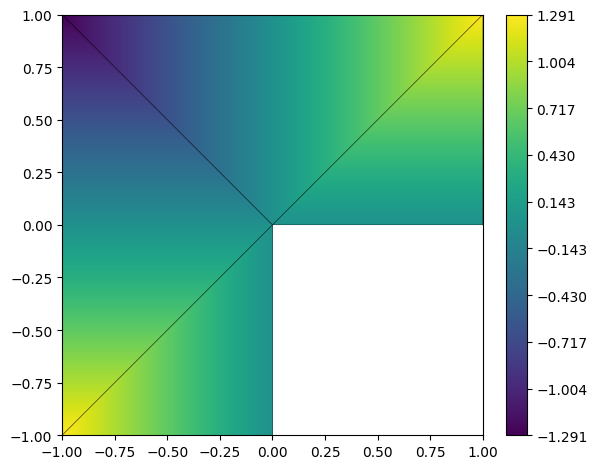

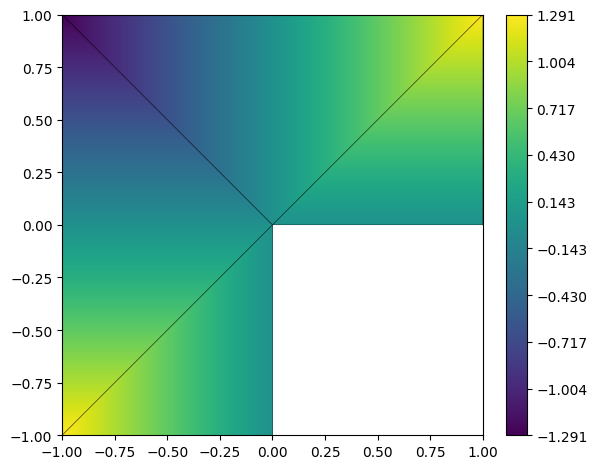

In [4]:
##### TASK
from dune.fem.function import gridFunction
@gridFunction(triangular_grid, codim=0, order=1)
def f(global_x):
    return np.array(np.linalg.norm(global_x) * np.sin(20 * global_x[0] * global_x[1]))
f.plot()

@gridFunction(triangular_grid, codim=0, order=1)
def g(element, local_x):
    global_x = element.geometry.toGlobal(local_x)
    return np.array(np.linalg.norm(global_x) * np.sin(20 * global_x[0] * global_x[1]))
g.plot()

Write a piecewise constant grid function that on each element returns
the absolute value of the center of the element.

Note: the return value of `geometry.center` provides an attribute
`two_norm`:

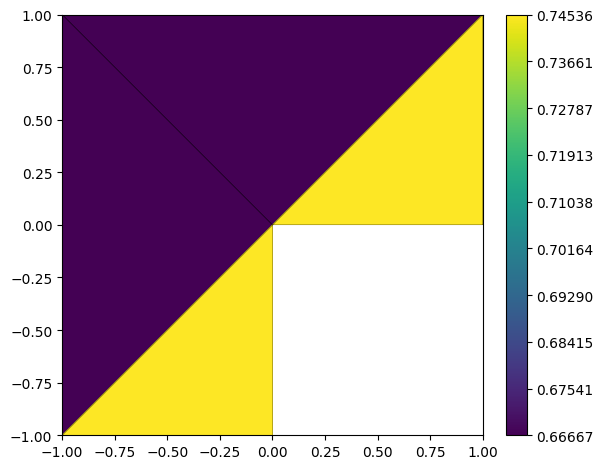

In [5]:
##### TASK
@gridFunction(triangular_grid, codim=0, order=1)
def abs_value_center(element, x):
    return element.geometry.center.two_norm
abs_value_center.plot()

Independent of the signature of the function used,
one can evaluate each grid function given an element
and a local coordinate.

Iterate over the grid and print the value of all your your grid functions
in the center of the elements.

In [6]:
##### TASK
for element in triangular_grid.elements:
    print(f"first function value at center: {f(element, element.geometry.center)}")
    print(f"second function value at center: {g(element, element.geometry.center)}")
    print(f"third function value at center: {abs_value_center(element, element.geometry.center)}")


first function value at center: 0.8340259468681642
second function value at center: 0.8340259468681642
third function value at center: 0.7453559924999299
first function value at center: 1.9745475197487317
second function value at center: 1.9745475197487317
third function value at center: 0.6666666666666667
first function value at center: -1.4802973661668749e-15
second function value at center: -1.4802973661668749e-15
third function value at center: 0.74535599249993
first function value at center: -0.39439002598662926
second function value at center: -0.39439002598662926
third function value at center: 0.6666666666666667


Refine the grid a few times (three times for example) and plot all
functions again. You can also do a 'virtual' refinement by using the
'level' parameter so add 'level=3' to the plot function.

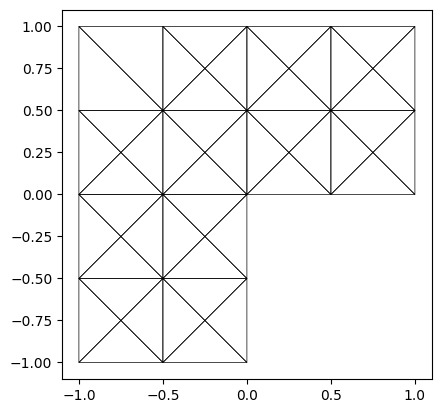

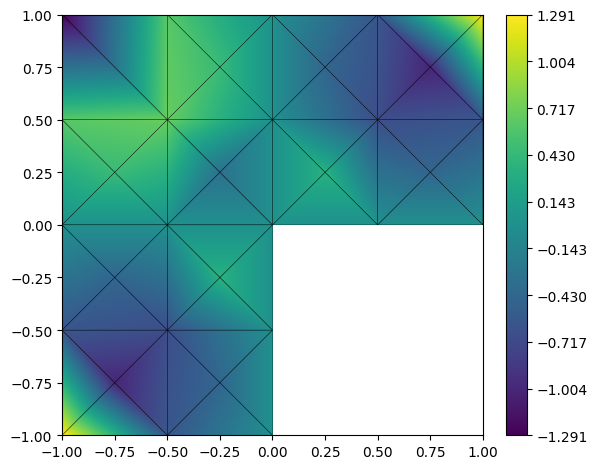

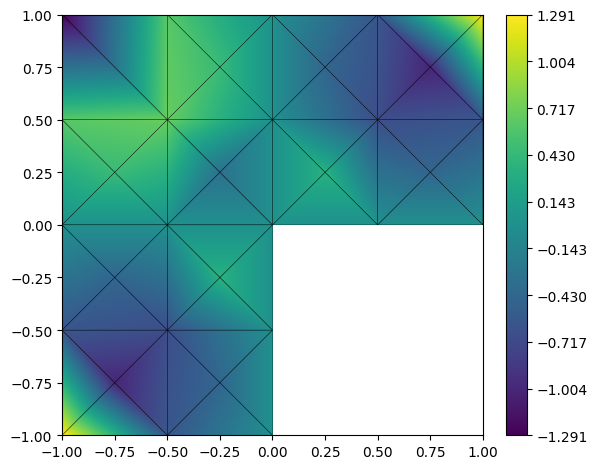

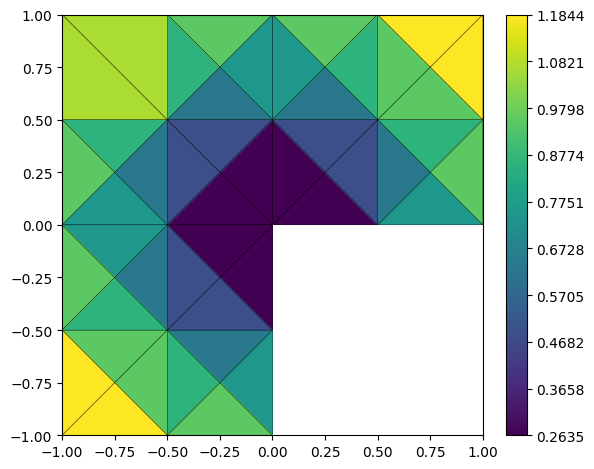

In [7]:
##### TASK
triangular_grid.hierarchicalGrid.globalRefine(3)
triangular_grid.plot()
f.plot()
g.plot()
abs_value_center.plot()

Finally we can write vtk files which can be viewed
with some third party software e.g. `paraview` -
```Python
view.writeVTK("sin", pointdata=(f1,f2,center])
```

## Attaching data to the grid
For this we use a `mapper` $g_T$ provided by the
grid. It is constructed by passing in a `layout`,
i.e., how many degrees of freedom are needed per
subentity (in fact per `geometry` type...)

Let's attach two degree of freedom to each
vertex and one degree of freedom to each edge and print
the number of dofs for a Cartesian grid with 3x2 cells:

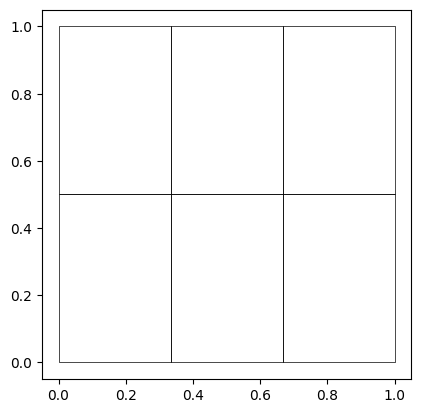

41


In [19]:
##### TASK
layout = [0,1,2]
cartesian_grid = dune.grid.structuredGrid((0, 0), (1, 1), (3, 2))
cartesian_grid.plot()
mapper = cartesian_grid.mapper(layout)
print(mapper.size)

The easiest way to access all indices attach to an element, i.e.,
the vector $\big(\mu_T(i)\big)_i$, # is to call the method
`indices=mapper(element)`.

The vector of indices contains first the indices for the vertices
then come the edges,..., down (or up) to the element's global indices.

The order for each set of subentities depends on their
numbering in the Dune reference element.

Iterate over the grid and print the indices attached to each element:
Draw a sketch of the grid and try to see if you understand the results...

In [18]:
##### TASK
for elements in cartesian_grid.elements:
    indices = mapper(elements)
    print(indices)

[17 18 19 20 25 26 27 28  9 10  0  3]
[19 20 21 22 27 28 29 30 10 11  1  4]
[21 22 23 24 29 30 31 32 11 12  2  5]
[25 26 27 28 33 34 35 36 13 14  3  6]
[27 28 29 30 35 36 37 38 14 15  4  7]
[29 30 31 32 37 38 39 40 15 16  5  8]


Now to some 'real' example:
we compute the linear interpolation of a grid function $u$
over a triangular grid.

We need to attach one degree of freedom to each vertex $p$
which corresponds to the value of the function at $p$.
We store the degrees of freedom in a numpy array.

On each triangle with vertices $p_0,p_1,p_2$
the discrete function is now given by the unique
linear function taking the values
$u(p_0),u(p_1),u(p_2)$
at the three vertices. This function is
\begin{align*}
  u_h(e,\hat x) = u(p_0)(1-\hat x_0-\hat x_1)+u(p_1)\hat x_0+u(p_2)\hat x_1
\end{align*}
where $\hat x_0, \hat x_1$ is the coordinate in the reference element.

Write a function `linear interpolation` that takes a grid function `u`
and a grid view and returns the mapper and vector of degrees of freedom (dofs),
i.e., the numpy array storing the values of `u` at the vertices.

Note: note that a grid function has an attribute `view`.

Then write a grid function `u_h` that returns the linear interpolation
for the given dof vector and mapper.

Use the unstructured grid you setup before and refine it 3 time globally.

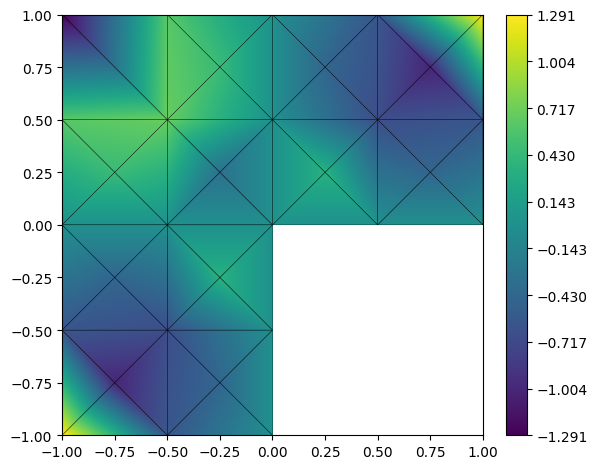

In [36]:
##### TASK

def linear_interpolate(u, grid_view):
    mapper = grid_view.mapper([0, 0, 1])
    data = np.zeros(mapper.size)
    for vertices in grid_view.vertices:
        indices = mapper.index(vertices)
        data[indices] = u(vertices.geometry.center)
    return mapper, data


@gridFunction(triangular_grid, order=1)
def u_h(element, x):
    mapper, data = linear_interpolate(f, triangular_grid)
    local_indices = mapper.subIndices(element, 2)
    weight_vector = np.array([1 - x[0] - x[1], x[0], x[1]])
    return np.array([data[idx] * weight for idx, weight  in zip(local_indices,weight_vector)]).sum()
u_h.plot()


Let's compute the maximum interpolation error by
comparing the linear interpolation `u_h` at the
center of each element with the value of `u` and printing
the maximum value:

In [42]:
##### TASK

max_error = np.max([np.abs(u_h(element, element.geometry.center) - f(element, element.geometry.center)) for element in triangular_grid.elements])
print(f"max error is {max_error}")

max error is 2.8437848494833
